# BBC News Category Classification with Linear SVM

This notebook reproduces the SVM-based text classification workflow built for the BBC news dataset.
We proceed step by step, explaining every helper function and showing the intermediate results, including simple visualizations built with Matplotlib.

## Roadmap
1. Load required libraries and configure the environment.
2. Ensure NLTK corpora are available for tokenization and lemmatization.
3. Inspect the raw dataset and explore class distribution and document lengths.
4. Build a reusable text preprocessing pipeline with a custom tokenizer.
5. Train and tune a Linear SVM classifier using TF-IDF features.
6. Evaluate the model with metrics, confusion matrix, and most informative terms.

## 1. Imports and configuration

In [1]:
from __future__ import annotations

import csv
from collections import Counter
from pathlib import Path
from typing import Dict, List, Sequence, Tuple

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (10, 6)
DATA_PATH = Path("bbc-news-data.csv")


### Why these imports?
* `csv`, `Path`, and typing helpers let us load the TSV dataset safely.
* NLTK provides stop word lists, tokenization, and lemmatization for linguistic preprocessing.
* Scikit-learn supplies the TF-IDF vectorizer, SVM classifier, and evaluation utilities.
* Matplotlib gives us quick visualizations for dataset exploration and evaluation.

## 2. Helper to download NLTK resources

The tokenizer we will build relies on three NLTK corpora:
* `stopwords` to filter out common words.
* `wordnet` for lemmatization (reducing words to their base form).
* `punkt` for robust sentence and word tokenization.

The function below checks for each resource and downloads it on demand.

In [2]:

def ensure_nltk_resources() -> None:
    """Download the NLTK corpora required by the tokenizer if they are missing."""
    resources = {
        "corpora/stopwords": "stopwords",
        "corpora/wordnet": "wordnet",
        "tokenizers/punkt": "punkt",
    }
    for resource_path, resource_name in resources.items():
        try:
            nltk.data.find(resource_path)
        except LookupError:
            nltk.download(resource_name)


Run the helper once so later steps can tokenize text without interruptions.

In [3]:
ensure_nltk_resources()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Azuréa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 3. Loading and inspecting the dataset

The BBC dataset ships as a tab-separated file with four columns: category, filename, title, and content.
The loader below preserves only the title and article body, concatenating them into a single text field.

In [4]:

def load_bbc_dataset(path: Path) -> Tuple[List[str], List[str]]:
    """Read the TSV file and return two parallel lists: texts and their category labels."""
    texts: List[str] = []
    labels: List[str] = []
    with path.open(encoding="utf-8") as handle:
        reader = csv.DictReader(handle, delimiter="	")
        for row in reader:
            document = " ".join([
                row.get("title", "").strip(),
                row.get("content", "").strip(),
            ]).strip()
            if not document:
                continue
            texts.append(document)
            labels.append(row["category"])
    if not texts:
        raise ValueError(f"No documents found in {path}")
    return texts, labels


In [5]:
texts, labels = load_bbc_dataset(DATA_PATH)

label_lookup: Dict[str, str] = {}
for text, label in zip(texts, labels):
    if text in label_lookup and label_lookup[text] != label:
        raise ValueError("Detected the same document with conflicting labels.")
    label_lookup[text] = label

num_documents_raw = len(texts)
unique_pairs = list(dict.fromkeys(zip(texts, labels)))
if len(unique_pairs) != num_documents_raw:
    print(f"Removed {num_documents_raw - len(unique_pairs)} duplicate documents to avoid leakage.")
texts, labels = zip(*unique_pairs)
texts, labels = list(texts), list(labels)

num_documents = len(texts)
unique_labels = sorted(set(labels))
print(f"Corpus size after deduplication: {num_documents} documents across {len(unique_labels)} categories.")
num_documents, unique_labels


Removed 98 duplicate documents to avoid leakage.
Corpus size after deduplication: 2127 documents across 5 categories.


(2127, ['business', 'entertainment', 'politics', 'sport', 'tech'])

Display the first three entries to understand how raw texts look.

In [6]:

for idx in range(3):
    print(f"Document #{idx + 1} | category={labels[idx]}")
    snippet = " ".join(texts[idx].split()[:60])
    print(snippet + ("..." if len(texts[idx].split()) > 60 else ""))
    print("-" * 80)


Document #1 | category=business
Ad sales boost Time Warner profit Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier. The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from...
--------------------------------------------------------------------------------
Document #2 | category=business
Dollar gains on Greenspan speech The dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise. And Alan Greenspan highlighted the US government's willingness to curb spending and rising household savings as factors which may help to reduce it. In late trading in...
--------------------------------------------------------------------------------
Document #3 | category=business
Yukos

### Class distribution

In [7]:

label_counts = Counter(labels)
for name, count in label_counts.items():
    print(f"{name:>13}: {count}")


     business: 503
entertainment: 369
     politics: 403
        sport: 505
         tech: 347


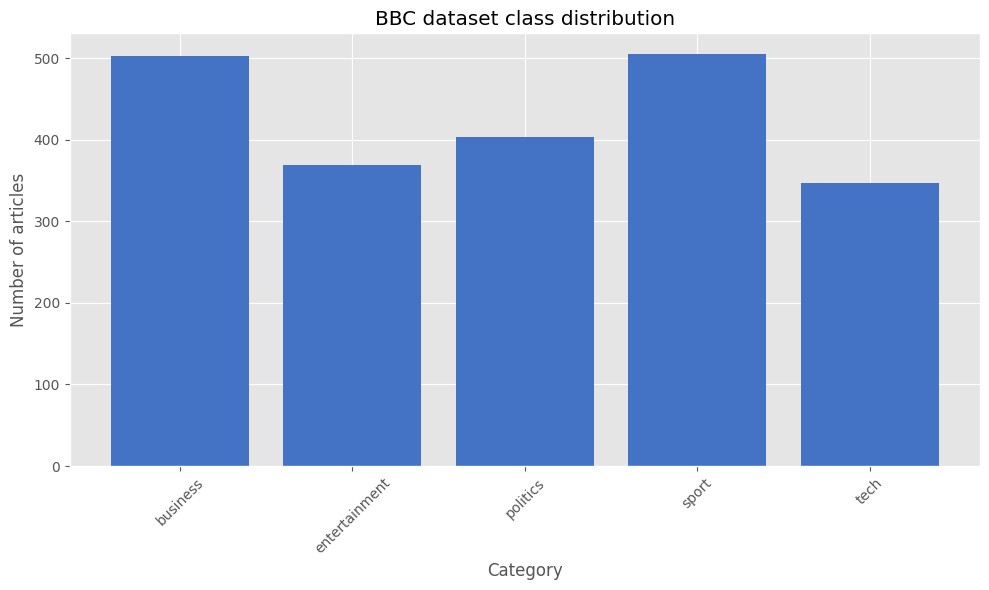

In [8]:

fig, ax = plt.subplots()
ax.bar(label_counts.keys(), label_counts.values(), color="#4472c4")
ax.set_xlabel("Category")
ax.set_ylabel("Number of articles")
ax.set_title("BBC dataset class distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Document length overview

In [9]:

document_lengths = [len(text.split()) for text in texts]
print(f"Average length: {np.mean(document_lengths):.1f} words")
print(f"Median length: {np.median(document_lengths):.1f} words")
print(f"Shortest article: {np.min(document_lengths)} words")
print(f"Longest article: {np.max(document_lengths)} words")


Average length: 384.1 words
Median length: 331.0 words
Shortest article: 89 words
Longest article: 4432 words


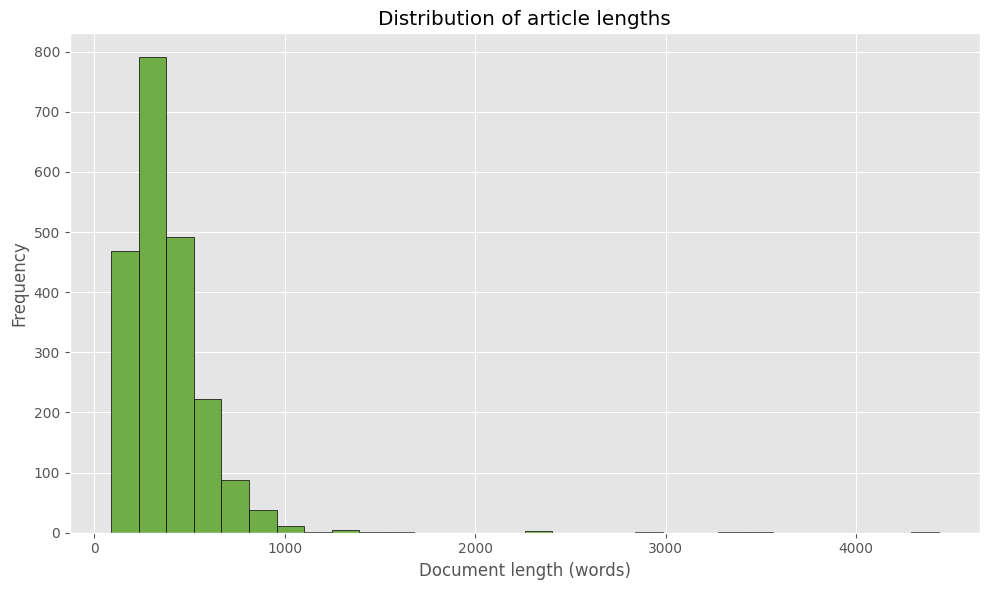

In [10]:

fig, ax = plt.subplots()
ax.hist(document_lengths, bins=30, color="#70ad47", edgecolor="black")
ax.set_xlabel("Document length (words)")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of article lengths")
plt.tight_layout()
plt.show()


## 4. Custom tokenizer

The Linear SVM will operate on TF-IDF features built from tokens returned by the class below.
* It converts text to lowercase tokens using NLTK's `word_tokenize`.
* It removes tokens containing non-alphabetical characters and filters stop words.
* It lemmatizes each token to keep morphological variants together.

In [11]:

class LemmaTokenizer:
    """Callable tokenizer that lemmatizes tokens and removes noise."""

    def __init__(self) -> None:
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words("english"))

    def __call__(self, text: str) -> List[str]:
        tokens = nltk.word_tokenize(text)
        cleaned_tokens: List[str] = []
        for token in tokens:
            token_lower = token.lower()
            if not token_lower.isalpha():
                continue
            if token_lower in self.stop_words:
                continue
            cleaned_tokens.append(self.lemmatizer.lemmatize(token_lower))
        return cleaned_tokens


In [12]:

tokenizer = LemmaTokenizer()
sample_tokens = tokenizer(texts[0])[:20]
sample_tokens


['ad',
 'sale',
 'boost',
 'time',
 'warner',
 'profit',
 'quarterly',
 'profit',
 'u',
 'medium',
 'giant',
 'timewarner',
 'jumped',
 'three',
 'month',
 'december',
 'firm',
 'one',
 'biggest',
 'investor']

## 5. Building the TF-IDF + Linear SVM pipeline

We wrap preprocessing and the classifier into a single scikit-learn pipeline.
The helper below constructs the TF-IDF vectorizer with our custom tokenizer and a LinearSVC classifier.

In [13]:

def build_pipeline() -> Pipeline:
    """Create a reusable pipeline that vectorizes text and fits a Linear SVM."""
    vectorizer = TfidfVectorizer(
        tokenizer=LemmaTokenizer(),
        token_pattern=None,
        lowercase=False,
        ngram_range=(1, 2),
        min_df=2,
    )
    classifier = LinearSVC()
    return Pipeline([("tfidf", vectorizer), ("clf", classifier)])


## 6. Training, tuning, and evaluation helpers

The next function performs a stratified train/test split and optionally tunes hyperparameters with grid search.
It returns the fitted model alongside the hold-out data and predictions so we can run analyses afterwards.

In [14]:
def train_and_evaluate(
    texts: Sequence[str],
    labels: Sequence[str],
    *,
    test_size: float = 0.2,
    random_state: int = 42,
    use_grid_search: bool = True,
) -> Tuple[Pipeline, List[str], List[str], List[str], List[str], List[str]]:
    """Train the Linear SVM pipeline and evaluate it on a hold-out split."""
    X_train, X_test, y_train, y_test = train_test_split(
        list(texts),
        list(labels),
        test_size=test_size,
        stratify=labels,
        random_state=random_state,
    )

    pipeline = build_pipeline()

    if use_grid_search:
        param_grid = {
            "tfidf__ngram_range": [(1, 1), (1, 2)],
            "clf__C": [0.1, 1.0, 3.0, 10.0],
        }
        search = GridSearchCV(
            pipeline,
            param_grid=param_grid,
            n_jobs=1,
            cv=5,
            verbose=1,
        )
        search.fit(X_train, y_train)
        print("Best parameters:", search.best_params_)
        print(f"Cross-validated accuracy: {search.best_score_:.4f}")
        pipeline = search.best_estimator_
    else:
        pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    return pipeline, X_train, y_train, X_test, y_test, list(y_pred)


We also define a helper to pull out the most influential TF-IDF features per class.
Large positive weights in the Linear SVM correspond to tokens that support a class decision.

In [15]:

def get_top_features(model: Pipeline, top_n: int = 15) -> Dict[str, List[Tuple[str, float]]]:
    """Return the top-N features per class, sorted by their SVM weights."""
    vectorizer: TfidfVectorizer = model.named_steps["tfidf"]
    classifier: LinearSVC = model.named_steps["clf"]
    feature_names = vectorizer.get_feature_names_out()

    top_features: Dict[str, List[Tuple[str, float]]] = {}
    for class_index, class_label in enumerate(classifier.classes_):
        coefs = classifier.coef_[class_index]
        top_indices = np.argsort(coefs)[-top_n:]
        ranked = [(feature_names[i], float(coefs[i])) for i in reversed(top_indices)]
        top_features[class_label] = ranked
    return top_features


### Train the model

In [16]:
model, X_train, y_train, X_test, y_test, y_pred = train_and_evaluate(texts, labels)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'clf__C': 1.0, 'tfidf__ngram_range': (1, 2)}
Cross-validated accuracy: 0.9777


### Data leakage checks


In [17]:
train_set = set(X_train)
test_set = set(X_test)
overlap = train_set.intersection(test_set)

print(f"Train split size: {len(X_train)}")
print(f"Test split size : {len(X_test)}")
print(f"Overlap between splits: {len(overlap)} documents")

if overlap:
    print("Warning: overlapping documents detected (showing up to 3 snippets).")
    for text in list(overlap)[:3]:
        snippet = " ".join(text.split()[:30])
        print(f"- {snippet}...")
else:
    print("No overlap detected between train and test splits.")


Train split size: 1701
Test split size : 426
Overlap between splits: 0 documents
No overlap detected between train and test splits.


### Classification metrics

In [18]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy:.4f}")
print("\nClassification report:\n")
print(classification_report(y_test, y_pred))


Test accuracy: 0.9859

Classification report:

               precision    recall  f1-score   support

     business       1.00      0.97      0.98       101
entertainment       0.97      0.99      0.98        74
     politics       0.99      0.99      0.99        81
        sport       1.00      1.00      1.00       101
         tech       0.96      0.99      0.97        69

     accuracy                           0.99       426
    macro avg       0.98      0.99      0.98       426
 weighted avg       0.99      0.99      0.99       426



### Confusion matrix

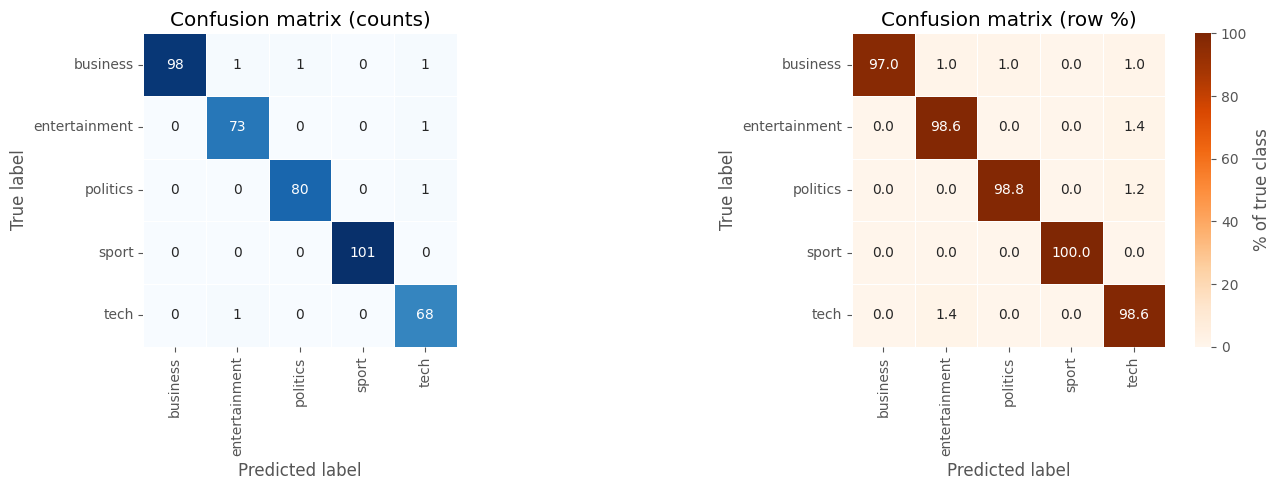

In [19]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
cm_norm = cm.astype(float)
row_sums = cm_norm.sum(axis=1, keepdims=True)
cm_norm = np.divide(cm_norm, row_sums, out=np.zeros_like(cm_norm), where=row_sums != 0)
cm_percent = cm_norm * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=False,
    square=True,
    linewidths=0.5,
    xticklabels=model.classes_,
    yticklabels=model.classes_,
    ax=axes[0],
)
axes[0].set_title('Confusion matrix (counts)')
axes[0].set_xlabel('Predicted label')
axes[0].set_ylabel('True label')

heatmap_norm = sns.heatmap(
    cm_percent,
    annot=True,
    fmt='.1f',
    cmap='Oranges',
    cbar=True,
    square=True,
    linewidths=0.5,
    xticklabels=model.classes_,
    yticklabels=model.classes_,
    ax=axes[1],
    cbar_kws={'label': '% of true class'},
)
axes[1].set_title('Confusion matrix (row %)')
axes[1].set_xlabel('Predicted label')
axes[1].set_ylabel('True label')

colorbar = heatmap_norm.collections[0].colorbar
colorbar.set_ticks(np.linspace(0, 100, 6))

plt.tight_layout()
plt.show()


### Inspect misclassified samples

In [20]:

errors = []
for text, truth, prediction in zip(X_test, y_test, y_pred):
    if truth != prediction:
        snippet = " ".join(text.split()[:50])
        errors.append((truth, prediction, snippet))

print(f"Total misclassifications: {len(errors)}")
for truth, prediction, snippet in errors[:5]:
    print("-" * 80)
    print(f"True label   : {truth}")
    print(f"Predicted    : {prediction}")
    print(f"Snippet      : {snippet}...")


Total misclassifications: 6
--------------------------------------------------------------------------------
True label   : business
Predicted    : politics
Snippet      : Golden rule 'intact' says ex-aide Chancellor Gordon Brown will meet his golden economic rule "with a margin to spare", according to his former chief economic adviser. Formerly one of Mr Brown's closest Treasury aides, Ed Balls hinted at a Budget giveaway on 16 March. He said he hoped more would...
--------------------------------------------------------------------------------
True label   : politics
Predicted    : tech
Snippet      : UK firms 'embracing e-commerce' UK firms are embracing internet trading opportunities as never before, e-commerce minister Mike O'Brien says. A government-commissioned study ranked the UK third in its world index of use of information and communication technology (ICT). The report suggests 69% of UK firms are now using broadband and...
---------------------------------------------------

### Most informative terms per class

In [21]:

top_terms = get_top_features(model, top_n=15)
for label, terms in top_terms.items():
    joined = ', '.join(term for term, _ in terms)
    print(f"{label:>13}: {joined}")


     business: bank, firm, company, share, market, price, economic, economy, profit, business, airline, oil, investment, trade, u
entertainment: film, show, star, singer, band, album, music, book, actor, ballet, song, ticket, festival, artist, award
     politics: party, mp, labour, blair, mr, minister, tory, committee, lord, secretary, council, police, election, government, straw
        sport: match, player, cup, coach, club, win, injury, champion, season, rugby, olympic, seed, athletics, side, liverpool
         tech: technology, computer, game, software, digital, user, online, mobile, pc, phone, network, ink, site, apple, website


Visualize the relative weights for one class (business) as a bar chart.

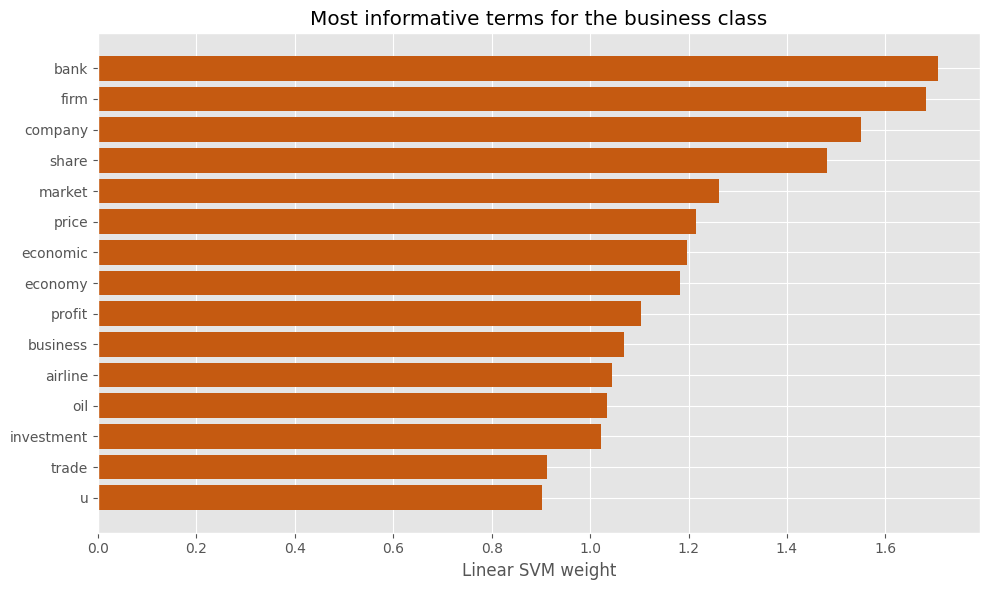

In [22]:

terms, weights = zip(*top_terms["business"][::-1])
fig, ax = plt.subplots()
ax.barh(terms, weights, color="#c55a11")
ax.set_xlabel("Linear SVM weight")
ax.set_title("Most informative terms for the business class")
plt.tight_layout()
plt.show()


## 7. Conclusion
We reproduced the SVM lab exercise inside a single notebook with detailed commentary.
The Linear SVM with TF-IDF features achieves high accuracy on the BBC dataset, and the visualizations help
explain both the dataset characteristics and the model's decisions.